## Import libraries

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load the data

In [19]:
Experiment = 'GRM2_GtACR_optoinhibition'
animal = 'SP160'
# output_folder =  '/home/sthitapati/Documents/sequence_data/seq_optoinhibition/output'
output_folder =  '/mnt/ceph/projects/sequences/analysed_data/behaviour_output'

# file name

folder = os.path.join(output_folder, Experiment, animal)
print(folder) 


/mnt/ceph/projects/sequences/analysed_data/behaviour_output/GRM2_GtACR_optoinhibition/SP160


In [20]:
# print contents of the folder
print('contents of the folder:')
for file in os.listdir(folder):
    print(file)

# load file with the name animal + _transition_data_all_sessions.csv

file_name = os.path.join(animal + '_transition_data_all_sessions.csv')
print(f'loading file ... {file_name}')

contents of the folder:
Preprocessed
SP160_session_info.csv
plots
SP160_transition_data_all_sessions.csv
loading file ... SP160_transition_data_all_sessions.csv


In [21]:
# load file_name as pandas dataframe
df = pd.read_csv(os.path.join(folder, file_name))
# df.head()

# print column names
print('column names:')
for col in df.columns:
    print(col)


column names:
Unnamed: 0
trial_id
transition_type
start_poke_port
end_poke_port
start_poke_in_timestamp
start_poke_out_timestamp
end_poke_in_timestamp
end_poke_out_timestamp
out_in_latency
in_in_latency
repeat_filter
2s_time_filter_out_in
2s_time_filter_in_in
opto_condition
opto_stimulated_port
training_level
led_intensities_ports_2_3_4_5
reward_amounts_ports_1_2_3_4
camera_port_in_times
camera_port_out_times
camera_trial_start_times
camera_trial_end_times
cumulative_trial_id
session_id
date
day
animal_id
group


In [22]:
# print all unique values in the column 'session_id'

print('unique values in the column session_id:')
print(df['session_id'].unique())

unique values in the column session_id:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [23]:
# state which sessions would you like to summarise
sessions_to_summarise = [13, 14, 15, 16, 17, 18, 19]

# create a new dataframe with only the sessions you want to summarise

df_s = df[df['session_id'].isin(sessions_to_summarise)]
# df_s.head()
# df_s['session_id'].unique()

df_s.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25630 entries, 27116 to 52745
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     25630 non-null  int64  
 1   trial_id                       25630 non-null  int64  
 2   transition_type                25630 non-null  int64  
 3   start_poke_port                25630 non-null  int64  
 4   end_poke_port                  25630 non-null  int64  
 5   start_poke_in_timestamp        25630 non-null  float64
 6   start_poke_out_timestamp       25630 non-null  float64
 7   end_poke_in_timestamp          25630 non-null  float64
 8   end_poke_out_timestamp         25628 non-null  float64
 9   out_in_latency                 25630 non-null  float64
 10  in_in_latency                  25630 non-null  float64
 11  repeat_filter                  25630 non-null  int64  
 12  2s_time_filter_out_in          25630 non-null  

## Accumulate the data into a single dataframe

In [24]:

def filter_dataframe(df, start_port=2, filter_sequence_from_start_port=True):
    """
    Filters a DataFrame based on the occurrence of a specified starting port and optionally
    sequences that begin from this port. The function adjusts timestamps to reference from the
    first occurrence of the starting port and condenses subsequent data to array structures for each trial.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing behavioral experiment data.
    - start_port (int): The start port number specifyuing the starting point of the sequence.
    - filter_sequence_from_start_port (bool): If True, sequences will be filtered to start from the first occurrence
      of the specified start_port. If False, the original starting point of the trial is used.

    Returns:
    - pd.DataFrame: A new DataFrame with trials filtered based on the start_port, and timestamps
      adjusted to start from the first occurrence of start_port.
    """
    # List to store the updated rows
    filtered_rows = []

    # Loop through each unique animal_id
    for animal in df['animal_id'].unique():
        animal_df = df[df['animal_id'] == animal]

        # Loop through each unique cumulative_trial_id
        for trial_id in sorted(animal_df['cumulative_trial_id'].unique()):
            trial_df = animal_df[animal_df['cumulative_trial_id'] == trial_id]

            # Skip trials without the specified start_port

            if not (trial_df['start_poke_port'] == start_port).any():
                continue  # Skip trials without the specified start_port

            # Find the index of the first occurrence of start_port

            if filter_sequence_from_start_port:
                trial_start_index = trial_df[trial_df['start_poke_port'] == start_port].index.min()
            else:
                trial_start_index = trial_df.index.min() # Set trial_start_index to the first start_poke_port

            # Filter rows that occur at or after the trial_start_index

            updated_trial_df = trial_df.loc[trial_start_index:]

            # Set reference timestamp
            reference_timestamp = updated_trial_df.loc[trial_start_index, 'start_poke_in_timestamp']

            # Update timestamp columns and create lists

            updated_trial_df['start_poke_in_timestamp'] -= reference_timestamp
            updated_trial_df['start_poke_out_timestamp'] -= reference_timestamp
            updated_trial_df['end_poke_in_timestamp'] -= reference_timestamp
            updated_trial_df['end_poke_out_timestamp'] -= reference_timestamp

            updated_trial_df['in_in_latency'] = updated_trial_df['end_poke_in_timestamp'] - updated_trial_df['start_poke_in_timestamp']
            updated_trial_df['out_in_latency'] = updated_trial_df['end_poke_in_timestamp'] - updated_trial_df['start_poke_out_timestamp']

            # Condense the updated trial DataFrame to one row
            condensed_row = updated_trial_df.iloc[0].to_dict()

            # Convert specified columns to lists for consistent data structure
            array_columns = [
                'transition_type', 'start_poke_port', 'end_poke_port',
                'start_poke_in_timestamp', 'start_poke_out_timestamp',
                'end_poke_in_timestamp', 'end_poke_out_timestamp',
                'out_in_latency', 'in_in_latency', 'camera_port_in_times',
                'camera_port_out_times'
            ]

            # Ensure all specified columns are converted to lists for consistent data structure
            for column in array_columns:
                condensed_row[column] = updated_trial_df[column].tolist()

            # Calculate latency to start trial as a new column
            latency_to_start_trial = reference_timestamp - trial_df['start_poke_in_timestamp'].iloc[0]
            condensed_row['latency_to_start_trial'] = latency_to_start_trial

            filtered_rows.append(condensed_row)

    filtered_df = pd.DataFrame(filtered_rows)
    filtered_df.reset_index(drop=True, inplace=True)

    # Optionally, drop columns that are no longer necessary or relevant for further analysis
    unnecessary_columns = ['led_intensities_ports_2_3_4_5', 'reward_amounts_ports_1_2_3_4']
    filtered_df.drop(columns=unnecessary_columns, inplace=True, errors='ignore')

    return filtered_df
# # # Usage:
# filtered_control_df = filter_dataframe(control_df, filter_sequence_from_start_port=True)

In [25]:

filtered_df_s = filter_dataframe(df_s, filter_sequence_from_start_port=False)

## Summarise the number of non-stimulated and stimulated trials

In [26]:
# print in a nice format the counts of trials for each unique value in the column 'opto_stimulated_port'
# e.g. number of trials with opto_stimulated_port = 1: 10
#      number of trials with opto_stimulated_port = 2: 20
#      number of trials with opto_stimulated_port = nan: 30
# Assuming filtered_df_s is your DataFrame and 'opto_stimulated_port' is the column of interest.

print(f'summarizing opto-stimulation of {len(sessions_to_summarise)} sessions: {sessions_to_summarise}', end='\n\n')

# Count of non-stimulated (NaN) trials
non_stimulated_count = filtered_df_s['opto_stimulated_port'].isna().sum()
print('number of non-stimulated trials:', non_stimulated_count)

# Count of trials for each unique value in 'opto_stimulated_port'
value_counts = filtered_df_s['opto_stimulated_port'].value_counts(dropna=False)
for port in range(1, 5):
    print(f'number of trials with opto_stimulated_port = {port}:', value_counts.get(port, 0))

summarizing opto-stimulation of 7 sessions: [13, 14, 15, 16, 17, 18, 19]

number of non-stimulated trials: 2872
number of trials with opto_stimulated_port = 1: 27
number of trials with opto_stimulated_port = 2: 17
number of trials with opto_stimulated_port = 3: 20
number of trials with opto_stimulated_port = 4: 17


## Prepare the dataframe for plotting and summarising out_in_latency and port_in_times
the data is to be segragate into 5 groups: non-stimulated, port_1, port_2, port_3, port_4

In [27]:

# get out_in_latency and in_in_latency from df_s 

df_latency = df_s[['out_in_latency', 'in_in_latency', 'opto_stimulated_port', 'repeat_filter']].copy()

# add a column port_time = in_in_latency - out_in_latency
df_latency['port_time'] = df_latency['in_in_latency'] - df_latency['out_in_latency']

# reset index
df_latency.reset_index(drop=True, inplace=True)

df_latency.head()

# to simplify calculation of variable delay, we will only consider trials with port_time < 1 second
df_latency = df_latency[df_latency['port_time'] < 1]

# and remove trials with out_in_latency > 5 seconds to account for very long wait time before the next poke when the animal just decides to go have a mid-strength beer
df_latency = df_latency[df_latency['out_in_latency'] < 5]

# remove rows when there is repat of poke in the same port (repeat_filter = 0)

df_latency = df_latency[df_latency['repeat_filter'] == 1]


/home/sthitapati/anaconda3/envs/seq/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


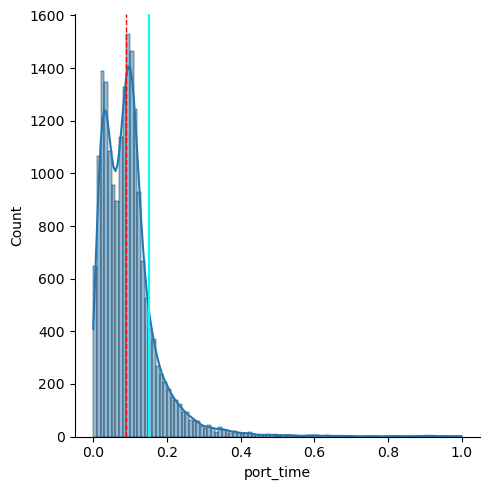

Vertical cyan line, 95th percentile of port_time: 0.23269000000002524
Vertical red line, median of port_time: 0.0880500000000097


In [28]:
# plot the distribution of df_latency['port_time'] 

sns.displot(df_latency['port_time'], bins=100, kde=True)

# draw a vertical line at the 75th percentile in the same plot

plt.axvline(x=np.percentile(df_latency['port_time'],85), color='cyan')
plt.axvline(x=np.median(df_latency['port_time']), color='red', linestyle='--', linewidth=1)
plt.show()

print('Vertical cyan line, 95th percentile of port_time:', np.percentile(df_latency['port_time'],95))
print('Vertical red line, median of port_time:', np.median(df_latency['port_time']))

/home/sthitapati/anaconda3/envs/seq/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


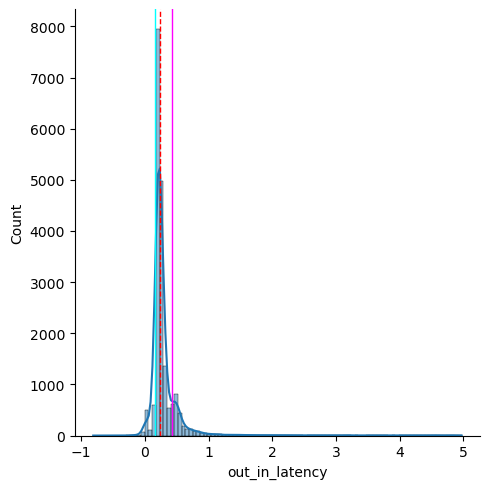

Vertical magenta line, 85th percentile of out_in_latency: 0.4220850000000041
Vertical red line, median of out_in_latency: 0.23254999999994647
Vertical cyan line, 85th percentile of port_time: 0.23269000000002524


In [29]:
# plot a histogram of df_latency['out_in_latency'] 

sns.displot(df_latency['out_in_latency'], bins=100, kde=True)

# draw a vertical line at the 75th percentile in the same plot

plt.axvline(x=np.percentile(df_latency['out_in_latency'],85), color='magenta', linewidth=1)
plt.axvline(x=np.median(df_latency['out_in_latency']), color='red', linestyle='--', linewidth=1)
# draw a cyan line at the 85th percentile of df_latency['port_time'] in the same plot
plt.axvline(x=np.percentile(df_latency['port_time'],85), color='cyan', linewidth=1)
plt.show()

print('Vertical magenta line, 85th percentile of out_in_latency:', np.percentile(df_latency['out_in_latency'],85))
print('Vertical red line, median of out_in_latency:', np.median(df_latency['out_in_latency']))
print('Vertical cyan line, 85th percentile of port_time:', np.percentile(df_latency['port_time'],95))

# plot

In [30]:
# lowerBound = np.percentile(df_latency['port_time'],95
# upperBound = np.percentile(df_latency['out_in_latency'],85
# mean_ = np.mean(df_latency['out_in_latency'])
# sd_ = np.std(df_latency['out_in_latency'])

print('mean of out_in_latency:', round(np.mean(df_latency['out_in_latency']), 2))
print('standard deviation of out_in_latency:', round(np.std(df_latency['out_in_latency']), 2))
print('lower bound of port_time:', round(np.percentile(df_latency['port_time'], 95), 2))
print('upper bound of out_in_latency:', round(np.percentile(df_latency['out_in_latency'], 85), 2))


mean of out_in_latency: 0.32
standard deviation of out_in_latency: 0.37
lower bound of port_time: 0.23
upper bound of out_in_latency: 0.42


## Summarise variable delay trials